## Makemore with an MLP architecture

* This part of makemore deals with the an MLP architecture to predict the next character in a sequence of letters.

* The training data here remains the same (`data/names.txt`).

* We implement the model from this research paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

* This paper deals with a vocabulary of 17000 words to predict the next word in a sentence.

* The architecture of the ML model introduced/used here looks something like this :

> <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-26_at_2.17.37_PM.png" alt=output width=60%>

* The researchers here have taken a block size 3, which means they have taken 3 words/logits/characters as input to predict the next word from it based of the vocabulary.

* Also, there is a lookup table of say (17000x30) where each time a word is selected, the entire row of 30 words gets used a neuron in the neural network.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('data/names.txt', 'r').read().lower().splitlines()
words[:5]

['olivia', 'emma', 'ava', 'charlotte', 'sophia']

In [3]:
len(words)

31517

In [4]:
# build the vocabulary of character and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3  # context length: number of characters do we take to predict the next one
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([222835, 3]), torch.int64, torch.Size([222835]), torch.int64)

In [8]:
def build_dataset(words):
    block_size = 3  # context length: number of characters do we take to predict the next one
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([178139, 3]) torch.Size([178139])
torch.Size([22333, 3]) torch.Size([22333])
torch.Size([22363, 3]) torch.Size([22363])


In [9]:
C = torch.randn((27, 2))

In [10]:
C[5]

tensor([-0.2010, -2.1388])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.2010, -2.1388])

In [12]:
emb = C[X]
emb.shape

torch.Size([222835, 3, 2])

In [13]:
W1 = torch.randn((6, 100))  # weights in layer one
b1 = torch.randn(100)  # biases in layer one

In [14]:
h0 = emb.view(-1, 6) @ W1 + b1   # same as writing "emb.view(emb.shape[0], 6) @ W1 + b1"
h = torch.tanh(h0)      # here, `tanh()` is used as an activation function of the nn

In [15]:
h   # the values in the tensor are between [-1, 1] because of `tanh`

tensor([[ 0.6202, -1.0000,  0.4273,  ...,  0.9591,  0.5040, -0.7299],
        [-0.7706, -1.0000,  0.9794,  ...,  0.9035,  0.8865, -0.6042],
        [ 0.6583, -1.0000,  0.8751,  ...,  0.9624,  0.7348, -0.8667],
        ...,
        [-0.1908, -0.9996,  0.9302,  ..., -0.8925,  0.9978,  0.3375],
        [ 0.9862, -0.9993, -0.3872,  ..., -0.9955,  0.9926,  0.4719],
        [-0.9986,  0.9951, -0.9234,  ..., -0.9761,  0.9999,  0.9999]])

In [16]:
h.shape

torch.Size([222835, 100])

In [17]:
W2 = torch.randn((100, 27))  # weights in layer two
b2 = torch.randn(27)  # biases in layer two

In [18]:
logits = h @ W2 + b2

In [19]:
logits.shape

torch.Size([222835, 27])

In [20]:
logits[:5]

tensor([[-5.7569e+00, -7.3462e+00, -8.9410e+00, -2.4684e+00, -9.0138e+00,
          4.0387e+00, -1.7912e+00,  1.1537e+01,  7.7723e+00, -9.7151e+00,
          3.8811e+00,  1.1325e+01,  6.4384e+00, -1.4813e+01, -2.4147e+00,
          4.4375e+00, -2.7984e+00,  8.6246e+00, -1.2003e+00,  4.3484e-01,
         -8.1979e+00, -8.0790e+00, -1.1859e+00, -2.3078e+00, -1.5101e+00,
          9.1982e-01,  5.0481e+00],
        [-4.5918e+00, -4.9470e+00, -8.4196e+00, -1.1631e+01, -1.3639e+01,
         -1.1840e+00, -4.9967e+00,  1.3036e+01,  8.4897e+00, -8.1761e+00,
         -4.2533e-01,  2.6294e+00,  1.0958e+01, -7.4616e+00, -3.0339e+00,
          8.2306e+00, -6.3891e+00,  5.9390e+00,  3.0212e+00,  9.2500e+00,
          3.0549e-01, -1.4785e-01, -9.4422e-01, -1.2414e+00,  4.7346e+00,
          7.5991e+00, -6.6661e-01],
        [ 3.0695e+00, -1.7178e+00, -1.0244e+01, -1.4223e+01, -1.6143e+00,
         -7.8009e+00, -1.9564e+01,  2.0248e+01,  1.6994e+01, -7.2460e+00,
          1.9170e-01, -1.1487e+00,  4.49

In [21]:
counts = logits.exp()
counts[:5]

tensor([[3.1608e-03, 6.4506e-04, 1.3091e-04, 8.4717e-02, 1.2172e-04, 5.6755e+01,
         1.6676e-01, 1.0241e+05, 2.3740e+03, 6.0365e-05, 4.8476e+01, 8.2832e+04,
         6.2542e+02, 3.6892e-07, 8.9397e-02, 8.4561e+01, 6.0910e-02, 5.5667e+03,
         3.0109e-01, 1.5447e+00, 2.7523e-04, 3.0998e-04, 3.0547e-01, 9.9475e-02,
         2.2090e-01, 2.5088e+00, 1.5572e+02],
        [1.0134e-02, 7.1045e-03, 2.2049e-04, 8.8832e-06, 1.1929e-06, 3.0606e-01,
         6.7604e-03, 4.5868e+05, 4.8642e+03, 2.8130e-04, 6.5355e-01, 1.3865e+01,
         5.7436e+04, 5.7471e-04, 4.8129e-02, 3.7542e+03, 1.6798e-03, 3.7955e+02,
         2.0515e+01, 1.0405e+04, 1.3573e+00, 8.6256e-01, 3.8898e-01, 2.8899e-01,
         1.1382e+02, 1.9964e+03, 5.1345e-01],
        [2.1531e+01, 1.7945e-01, 3.5586e-05, 6.6503e-07, 1.9902e-01, 4.0935e-04,
         3.1878e-09, 6.2183e+08, 2.3999e+07, 7.1301e-04, 1.2113e+00, 3.1704e-01,
         8.9235e+01, 6.9857e-02, 4.6319e-02, 3.0566e+02, 8.1889e-03, 2.5170e+02,
         1.0900e-

In [22]:
prob = counts / counts.sum(1, keepdims=True)

In [23]:
prob.shape, prob[0].sum()

(torch.Size([222835, 27]), tensor(1.))

In [37]:
prob[torch.arange(33), Y]

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [33], [222835]

### Making everything Respectable and Reproducible

In [25]:
Xtr.shape, Ytr.shape

(torch.Size([178139, 3]), torch.Size([178139]))

In [26]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [27]:
sum(p.nelement()for p in parameters)

11897

In [28]:
for p in parameters:
    p.requires_grad = True

In [29]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [30]:
lri = []
lossi = []
stepi = []

In [31]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(33), Y].log().mean()

    loss = F.cross_entropy(logits, Ytr[ix])   # same result as the 3 lines above
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameter
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track paths
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

# print(loss.item())

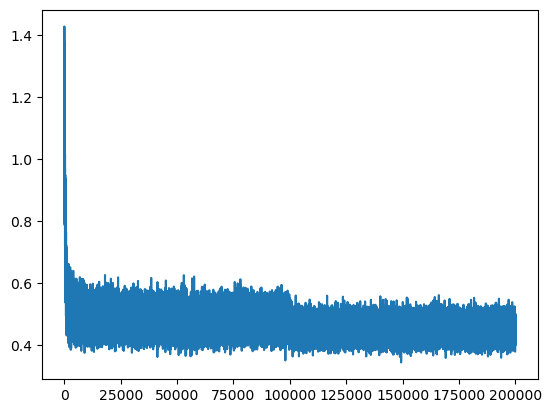

In [32]:
plt.plot(stepi, lossi)

In [33]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.8360, grad_fn=<NllLossBackward0>)

In [34]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.8446, grad_fn=<NllLossBackward0>)

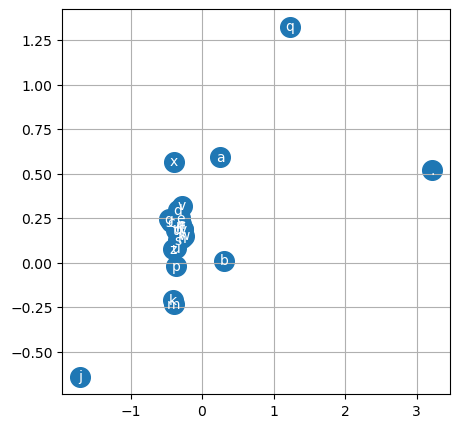

In [35]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(5, 5))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [36]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

eriaaimyaylseelmnd.
ryal.
.
ethrsjekdrleg.
azeeedieliihemy.
oealekeineananarneayzimhlkea.
n.
sadbnrglhimies.
.
n.
jr.
tllklxnteuoaou.
amned.
r.
ylruemehs.
laa.
hysknyaa.
hya.
aalyaisun.
zajelveuren.
